In [1]:
# Import relevant libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check if the paths are valid
tot_int = r"C:/Users/franc/Capstone/Code/tot_int.xlsx"
quant_int = r"C:/Users/franc/Capstone/Code/quant_int.xlsx"
avg_int = r"C:/Users/franc/Capstone/Code/avg_int.xlsx"

path = [tot_int, quant_int, avg_int]

# Assertion for loop    
for p in path:
    assert os.path.isfile(p)
    with open(p, "r") as f:
        pass

In [3]:
# Average cost (BRL) of hospitalization (per ICU type) in terms of daily utilization(2019-2021) | Source SIH-SUS
df_1= pd.read_excel(avg_int)
# Drop child ICU care
df_1= df_1.drop(columns=['UTI Infantil I', 'UTI Infantil II', 'UTI Infantil III', 'UTI Neonatal I', 'UTI Neonatal II', 'UTI Neonatal III', 'UTI II PEDIATRICO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19', 'Mais de um tipo de UTI/UCI utilizado'])
# Translation PT-BR -> EN-US
df_1.rename(columns={'Diárias de UTI': 'ICU days', 'Cirúrgico': 'Surgical',  'UTI Adulto II': 'Adult ICU II', 'UTI Adulto III': 'Adult ICU III', 'UTI I': 'ICU I',
 'UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19': 'COVID 19 Adult ICU II', 'UTI Coronariana-UCO tipo II' : 'Coronary ICU Type II', 'UTI Queimados':'Burned ICU', 'UTI Coronariana-UCO tipo III' : 'Coronary ICU Type III'}, inplace = True)
# See df
df_1


,ICU days,Surgical,Adult ICU II,Adult ICU III,Coronary ICU Type II,Coronary ICU Type III,ICU I,COVID 19 Adult ICU II,Burned ICU
0,1,0.000000,3854.482734,5376.412449,7211.069646,7355.641497,2152.112857,3272.255896,2573.773930
1,2,5443.287962,4259.191792,6157.676881,8450.939600,7565.794776,2466.357498,4951.079616,3185.175833
2,3,7124.668476,4621.715679,6816.730155,9291.437719,8039.807887,2575.626727,6606.211101,3491.285605
3,4,7805.196077,4966.150694,7177.331359,9844.122224,8967.518568,2933.863118,8257.677820,4392.495947
4,5,8522.901736,5338.166677,7735.600903,10847.917202,9908.161094,3094.803170,9925.802229,4801.915601
5,6,9430.479796,5726.083003,8158.969782,11605.209849,10981.846111,3430.507789,11598.046486,5240.633400
6,7,10283.386288,6182.744614,8639.860986,11974.669029,11376.218202,3212.628506,13255.133139,5288.569567
7,8 ≤ 14,13677.749330,8011.470458,10625.999120,14416.404328,14682.089401,3947.045060,19202.712466,7696.962753
8,15 ≤ 21,21070.697040,12131.984120,15262.176979,20590.098359,21854.807848,5333.818148,31066.307645,11644.748132
9,22 ≤ 28,28054.157997,16357.064036,20168.588472,28245.015367,28629.793584,6702.848425,43118.467099,14564.295976


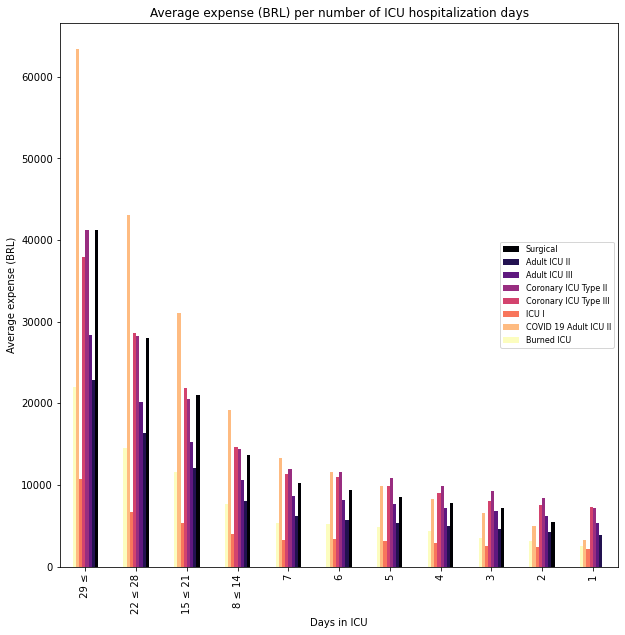

In [4]:
# Empty list will store name of columns
y_vals= []
# Loop over df and get the names of the columns
for name in df_1.columns:
    # Append to initially empty list
    y_vals.append(name)
# Remove days because it wont make sense since this will be the x-axis
y_vals.remove('ICU days')
# Define color map
color_map =  plt.cm.get_cmap('magma')
# Plot 
df_1.plot(x='ICU days', y= y_vals, kind = 'bar', figsize= (10,10), cmap= color_map)
# X label
plt.xlabel('Days in ICU')
# Y label
plt.ylabel('Average expense (BRL)')
# Define location for legend
plt.legend(loc=7, prop={'size': 8})
# Title for the plot
plt.title('Average expense (BRL) per number of ICU hospitalization days')
# Invert position of x-axis
plt.gca().invert_xaxis()



# Regression

### Considerations
<p> As a linear regression expects numerial inputs for both axis, the number of days in the ICU to be considered will be the mean of both numbers when dealing with an interval and 29 for the extreme point. The error will be further analyzed to see if the results are acceptable and that assumption can be made.

Summary of Surgical and ICU days 
 
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     207.4
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           1.60e-07
Time:                        17:16:20   Log-Likelihood:                -100.80
No. Observations:                  11   AIC:                             205.6
Df Residuals:                       9   BIC:                             206.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       171

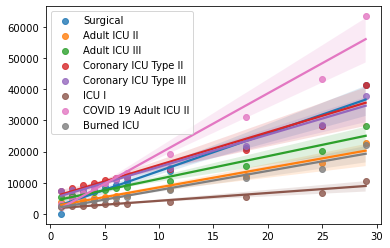

In [5]:
# Copy df to make sure the original data is ok
df_2=df_1.copy()
# Replace str by int, necessary for regression
df_2['ICU days'] = df_2['ICU days'].replace(['8 ≤ 14','15 ≤ 21','22 ≤ 28', ' 29 ≤'],[int(11), int(18), int(25), int(29)])
# Define X
X = np.array(df_2['ICU days'])
# Define X2 with linear model definition
X2 = sm.add_constant(X)

# Loop over all columns
for cov in df_2.columns:
    # Skip column with days
    if cov == 'ICU days':
        continue
    # Define y
    y = np.array(df_2[f'{cov}'])
    # Ordinary least squares
    est = sm.OLS(y, X2)
    # Fit regression
    est2 = est.fit()
    # Print summary of each regression
    print(f'Summary of {cov} and ICU days \n \n {est2.summary()}')
    # Plot regression
    sns.regplot(x=X, y=y, data=df_2, label= cov)

# Add caption to the regression
plt.legend()
    
   

